# Padaria Portugesa Geolocation

In [1]:
# classic import
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gp
import matplotlib.pyplot as plt
import warnings
import sys
import matplotlib as mpl
warnings.simplefilter('ignore')

# import local functions
path_to_functions = 'C:/Users/Zaca/Documents/GitHub/useful-functions/'
sys.path.append(path_to_functions)
from plotting import default_plot, get_colors

In [2]:
# matplotlib formatting
small = 10
medium = 12
large = 14

plt.rc('font', size=small)         # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', labelsize=small)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)   # fontsize of the tick labels
plt.rc('ytick', labelsize=small)   # fontsize of the tick labels
plt.rc('legend', fontsize=small)   # legend fontsize
plt.rc('figure', titlesize=large)   # fontsize of the figure title
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

In [52]:
# define functions

def horizontal_bar(data, rotation=0, name='figures/default_categorical_bar', save=False):
    
    # makes a categorical bar plot
    # input data has to be a dataframe with 3 columns
    # column 0 contains the labels that go on the x-axis (already pre-formatted)
    # column 1 contains the values
    # column 2 contains the colors
    # the title of the value-columns contains the label for the Y-axis
    # the name variable should contain path and filename to save to file
    
    data = data[::-1]
    
    size_dict = {4:4,
                 17:8}
    
    labels = list(data[data.columns[0]])
    labels = [str(len(labels) - i) + '. ' + labels[i] for i in range(len(labels))]
    values = list(data[data.columns[1]])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax = default_plot(ax, ['left'])
    x = range(len(values))
    
    ax.yaxis.set_tick_params(length=0)
    ax.spines['left'].set_visible(False)
    
    plt.ylim(-0.45, len(values) - 0.45)
    #plt.xlim(0, 1)

    xlabel = data.columns[1].replace('_',' ').title()
    ylabel = data.columns[0].replace('_',' ').title()

    plt.xlabel(xlabel)
    plt.yticks(x, labels)

    plt.vlines([10000, 20000, 30000], 0, 23, lw=.5, ls='dashed', alpha=.5, zorder=0)
    plt.barh(x, values, height=.9, color=data.colors, edgecolor='k', lw=.5)
    
    if save:
        plt.tight_layout()
        plt.savefig(name + '.png', dpi=100)
    
    plt.show()


In [4]:
# open data
freguesias = gp.read_file('data/freguesias.shp')
padarias = pd.read_csv('data/padarias.csv', index_col=0)
population = pd.read_csv('data/populacao-freguesias.csv', sep=';', engine='python', header=None, usecols=[1, 3, 4], names=['CODIGO','NOME', 'POP'])
population = population[(population['CODIGO'] == "'1106'") & (population['NOME'] != 'Lisboa')].reset_index()

# there were two duplicated restaurants in the same location
padarias.drop_duplicates(subset='restaurant.name', inplace=True)

In [ ]:
# add population values to freguesias dataset
pop_map = pd.Series(population.POP.values, index=population.NOME).to_dict()
freguesias['POP'] = freguesias['NOME'].map(pop_map)

In [5]:
# change projection to 2D in meters
freguesias = freguesias.to_crs('EPSG:3763')

In [6]:
# transform Zomato data into GeoDataFrame
padarias = gp.GeoDataFrame(padarias, geometry=gp.points_from_xy(padarias['restaurant.location.longitude'], padarias['restaurant.location.latitude']))

# transform from naive coordinates to the actual CRS system they are in.
padarias.crs = {'init' :'epsg:4326'}

# re-project to the same as the Lisbon map
padarias = padarias.to_crs('EPSG:3763')

In [7]:
# remove points outside the city
padarias = padarias[padarias.geometry.within(freguesias.unary_union)]

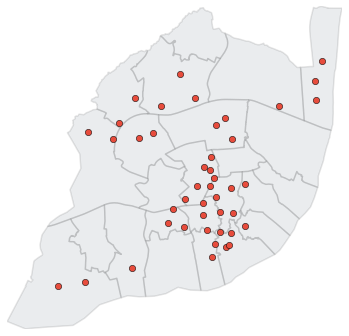

In [8]:
# plot base map and restaurant locations
base = freguesias.plot(figsize=(6, 6), facecolor='#34495e', edgecolor='black', linewidth= 1.5, alpha=.1)
padarias.plot(ax=base, marker='o', color='#e74c3c', markersize=40, edgecolor='k', linewidth=.5)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
#plt.savefig('figures/basemap_locations.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [9]:
# compute the 500m radius
circles = padarias.buffer(500)

In [10]:
# compute intersection between basemap and radiuses
intersection = circles.unary_union.intersection(freguesias.unary_union)

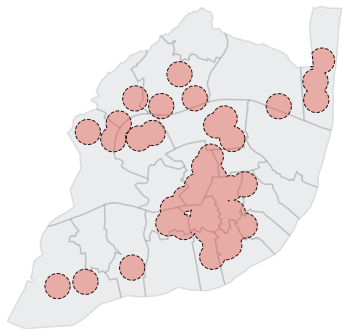

In [38]:
# plot new map
base = freguesias.plot(figsize=(6, 6), facecolor='#34495e', edgecolor='black', linewidth= 1.5, alpha=.1)
gp.GeoSeries(intersection).plot(ax=base, facecolor='none', edgecolor='k', lw=1, ls='dashed')
gp.GeoSeries(intersection).plot(ax=base, facecolor='#e74c3c', alpha=.4)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig('figures/area_difference.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [12]:
# compute percentage of area covered
area_covered = intersection.area/freguesias.unary_union.area
print(area_covered)

0.2504503331872856


In [13]:
# calculate insersection for each freguesia
intersections_all = freguesias['geometry'].intersection(circles.unary_union)

In [14]:
# compute area coverr for each freguesia
freguesias['area_covered'] = intersections_all.area/freguesias.area

In [15]:
# calculate population reached
freguesias['population_reached'] = freguesias['POP'] * freguesias['area_covered']
freguesias.sort_values(by='population_reached', ascending=False, inplace=True, ignore_index=True)

# grab colors
freguesias['colors'] = get_colors('viridis_r', freguesias.shape[0], plot=False)

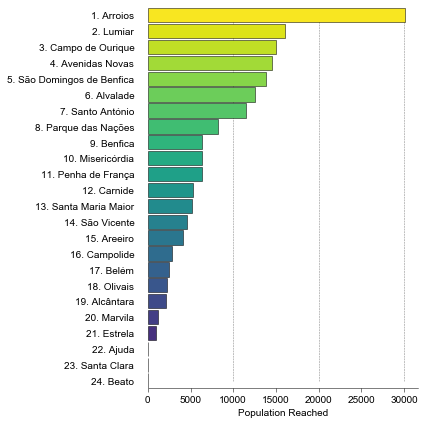

In [53]:
# make categorical and horizontal barplot
horizontal_bar(freguesias[['NOME', 'population_reached', 'colors']], save=True)

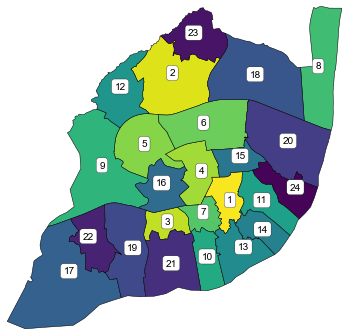

In [54]:
# get representative coordinate for each freguesia
freguesias['coords'] = freguesias['geometry'].apply(lambda x: x.representative_point().coords[:])
freguesias['coords'] = [coords[0] for coords in freguesias['coords']]

# plot annotated map
base = freguesias.plot(figsize=(6, 6), facecolor=freguesias['colors'], edgecolor='black', linewidth= .5, alpha=1)

# make number annotations
for idx, row in freguesias.iterrows():
    plt.annotate(s=str(idx+1), 
                 xy=row['coords'], 
                 horizontalalignment='center', 
                 bbox=dict(facecolor='white', edgecolor='black', lw=.3, boxstyle='round,pad=.3'))
    
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig('figures/freguesias_choropleth.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)

In [55]:
# compute population proportion
freguesias['population_reached'].sum()/freguesias['POP'].sum()

0.31129452001773983

In [71]:
freguesias['density'] = freguesias['POP']/freguesias['AREA_M2']

In [74]:
freguesias[['NOME','density','area_covered']].sort_values(by='are')

,NOME,density,area_covered
16,Belém,0.001585,0.149776
18,Alcântara,0.002747,0.154517
7,Parque das Nações,0.003868,0.392177
17,Olivais,0.004177,0.068017
12,Santa Maria Maior,0.004258,0.402034
20,Estrela,0.004372,0.045984
8,Benfica,0.004609,0.171418
23,Beato,0.005128,0.000000
11,Carnide,0.005210,0.273405
19,Marvila,0.005306,0.032862
